### Importing Libraries

In [4]:
import io
import random
import string
import warnings
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics


# python imports
import re
import json
import os
from collections import Counter
import datetime as dt
from dateutil.parser import parse


# Visualization
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from wordcloud import WordCloud
from tqdm import tqdm_notebook
import geopandas


# twitter
# pip install twarc
from twarc import Twarc
import carmen
import pycountry as pc

resolver = carmen.get_resolver()
resolver.load_locations()


# Saving models
import pickle

import config

/home/vca_rishik/anaconda3/lib/python3.7/site-packages/carmen-0.0.4-py3.7.egg/carmen/resolvers/profile.py:42: UserWarning: Duplicate location name "amman  jordan"
/home/vca_rishik/anaconda3/lib/python3.7/site-packages/carmen-0.0.4-py3.7.egg/carmen/resolvers/profile.py:42: UserWarning: Duplicate location name "amman jordan"
/home/vca_rishik/anaconda3/lib/python3.7/site-packages/carmen-0.0.4-py3.7.egg/carmen/resolvers/profile.py:42: UserWarning: Duplicate location name "st joseph county united states"
/home/vca_rishik/anaconda3/lib/python3.7/site-packages/carmen-0.0.4-py3.7.egg/carmen/resolvers/profile.py:42: UserWarning: Duplicate location name "st tammany parish united states"


### Reading the Data

In [5]:
main_dir = '/home/vca_rishik/rishik/COVID-19-tweets/'
full_dir = main_dir + 'data_full/'
id_dir   = main_dir + 'data/'

popularity_list = []
text_list = []
entities_list = []

for file in sorted(os.listdir(full_dir))[:-2]:
    print('reading... ' + file)
    
    df_full = pd.read_csv(full_dir + file)

    text_list.append(df_full[['id', 'full_text']])
    popularity_list.append(df_full[['id', 'retweet_count', 'favorite_count']])
    entities_list.append(df_full[['id', 'entities']])
    
    print(file + ' ..done')
    print()

reading... 05-01-2020_full.csv
05-01-2020_full.csv ..done

reading... 05-02-2020_full.csv
05-02-2020_full.csv ..done

reading... 05-03-2020_full.csv
05-03-2020_full.csv ..done

reading... 05-04-2020_full.csv
05-04-2020_full.csv ..done

reading... 05-05-2020_full.csv
05-05-2020_full.csv ..done

reading... 05-06-2020_full.csv
05-06-2020_full.csv ..done

reading... 05-07-2020_full.csv
05-07-2020_full.csv ..done

reading... 05-08-2020_full.csv
05-08-2020_full.csv ..done

reading... 05-09-2020_full.csv
05-09-2020_full.csv ..done

reading... 05-10-2020_full.csv
05-10-2020_full.csv ..done

reading... 05-11-2020_full.csv
05-11-2020_full.csv ..done

reading... 05-12-2020_full.csv
05-12-2020_full.csv ..done

reading... 05-13-2020_full.csv
05-13-2020_full.csv ..done

reading... 05-14-2020_full.csv
05-14-2020_full.csv ..done

reading... 05-15-2020_full.csv
05-15-2020_full.csv ..done

reading... 05-16-2020_full.csv
05-16-2020_full.csv ..done

reading... 05-17-2020_full.csv
05-17-2020_full.csv ..don

### Ananlysing hashtags

#### Dropping duplicates as there might be overlaps in the tweets from two consecutive days

In [25]:
df_entities = pd.concat(entities_list)
df_entities = df_entities.drop_duplicates().reset_index(drop = True)

df_entities = df_entities[:100000]

df_entities.tail()

,id,entities
99995,1.256244e+18,"{'hashtags': [{'text': 'coronavirus', 'indices..."
99996,1.256244e+18,"{'hashtags': [{'text': 'covid19', 'indices': [..."
99997,1.256244e+18,"{'hashtags': [{'text': 'Covid19', 'indices': [..."
99998,1.256244e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [..."
99999,1.256244e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [..."


#### Function to extract the hashtags from the entities excluding the ones used in the extraction of the tweets

In [26]:
query_hashtags = ["coronavirus", "coronavirusoutbreak", "coronaviruspandemic", "covid19", "covid_19", "epitwitter", "ihavecorona", "pandemic"]
def getHashtags(entity):
    if(isinstance(entity, str)):
        parsed = eval(entity)
        list_tags = [tag.get('text') for tag in parsed.get('hashtags') if tag.get('text').lower() not in query_hashtags]
        return list_tags
    
    return []

#### Adding a column to the dataframe conatining the hashtags from the tweet

In [27]:
df_entities['hashtags'] = df_entities.entities.apply(getHashtags)
df_entities.tail()


,id,entities,hashtags
99995,1.256244e+18,"{'hashtags': [{'text': 'coronavirus', 'indices...","[crisispr, pr, publicrelations, emergencymanag..."
99996,1.256244e+18,"{'hashtags': [{'text': 'covid19', 'indices': [...",[]
99997,1.256244e+18,"{'hashtags': [{'text': 'Covid19', 'indices': [...",[]
99998,1.256244e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",[]
99999,1.256244e+18,"{'hashtags': [{'text': 'COVID19', 'indices': [...",[SITEstrong]


#### Flattening the hashtags column

In [28]:
hashtags_list = df_entities.hashtags.apply(pd.Series).stack().reset_index(drop = True)
hashtags_list[:10]

0               SequoiaHR
1                      HR
2                Business
3                    ncdc
4         keepseniorssafe
5             Bracebridge
6                   China
7    QuarantineLifeBeLike
8                     Job
9          QuarantineLife
dtype: object

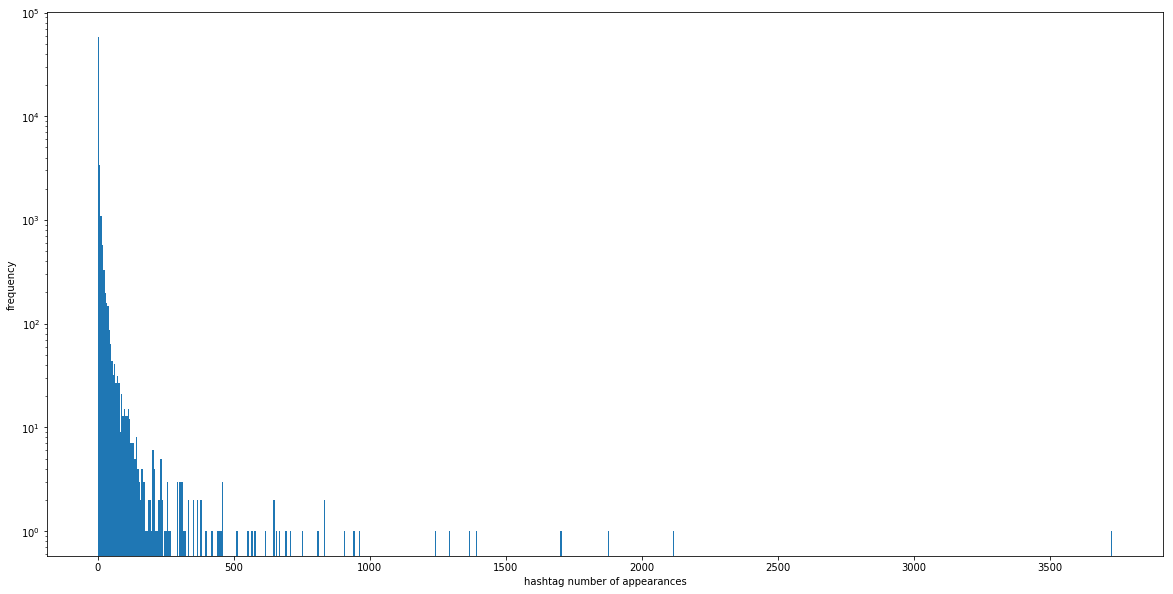

In [42]:
counts = hashtags_list.value_counts()
counts.sort_index()

my_bins = np.arange(0,counts.max()+2, 5)-0.5

# plot histogram of tweet counts
plt.figure(figsize=(20,10))
plt.hist(counts, bins = my_bins)
plt.xlabels = np.arange(1,counts.max()+1, 1)
plt.xlabel('hashtag number of appearances')
plt.ylabel('frequency')
plt.yscale('log', nonposy='clip')
plt.show()

In [67]:
popular_hashtags = counts.reset_index()
popular_hashtags.columns = ['hashtag', 'counts']
# popular_hashtags.dtypes

min_appearance = 500
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[popular_hashtags.counts.apply(lambda x: x > min_appearance)]['hashtag'])

print(len(popular_hashtags_set))
print(popular_hashtags_set)

27
{'covid', 'MayDay', 'COVIDー19', 'Trump', 'IndiaFightsCorona', 'India', 'stayhome', 'WorkersDay', 'Lockdown3', 'InternationalWorkersDay', 'Corona', 'lockdown', 'MayDay2020', 'LabourDay2020', 'China', 'COVID', 'StaySafe', 'StayHome', 'LabourDay', 'Lockdown', 'StayAtHome', 'corona', 'quarantine', 'staysafe', 'COVID__19', 'SocialDistancing', 'COVID2019'}


In [ ]:
# make a new column with only the popular hashtags
df_entities['popular_hashtags'] = df_entities.hashtags.apply(lambda hashtag_list: [hashtag for hashtag in hashtag_list if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = df_entities.loc[df_entities.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]
popular_hashtags_list_df.head()

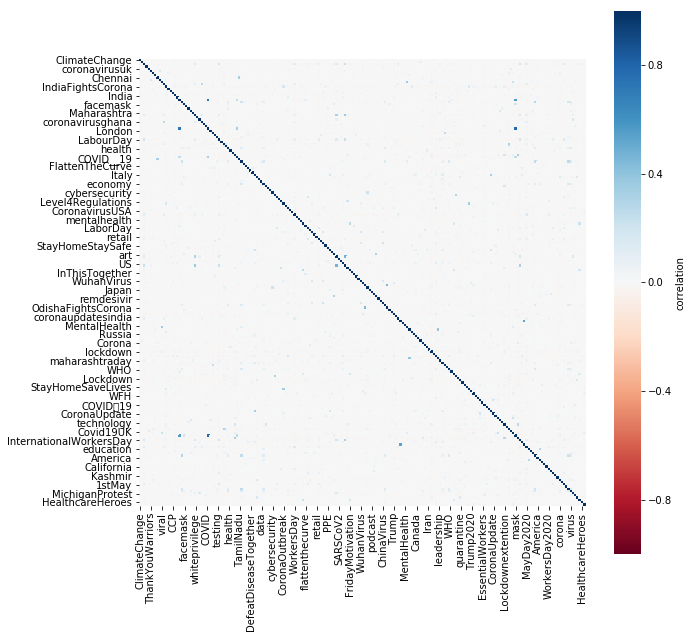

In [66]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(lambda hashtag_list: int(hashtag in hashtag_list))
    
hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

correlations = hashtag_matrix.corr()

# plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
    cmap='RdBu',
    vmin=-1,
    vmax=1,
    square = True,
    cbar_kws={'label':'correlation'})
plt.show()